# Policy Gradient on [`gym-anytrading`](https://github.com/AminHP/gym-anytrading)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.ppo import MLPLSTM, ActorCritic

from utils.functions import save_weights, load_config
from utils.rl import get_trading_env_args

from train_ppo import train_one_episode, evaluate_one_episode

In [3]:
import gym
import gym_anytrading

In [19]:
import torch.optim as optim
import torch 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf 

from tqdm.notebook import trange
import gc

In [20]:
gc.collect()

677

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [79]:
cfg = load_config("./config.yaml")
cfg

{'env': {'ticker': 'AAPL',
  'interval': '1d',
  'period': '2y',
  'train_prop': 0.8,
  'window_size': 10},
 'ppo': {'actor_critic': {'hidden_dim': 256, 'n_lstm_layers': 2},
  'hyperparameters': {'epsilon': 0.2,
   'steps': 5,
   'n_exps': 25,
   'print_freq': 10,
   'reward_threshold': 120,
   'profit_threshold': 2,
   'gamma': 0.99,
   'lr': 0.0001,
   'episodes': 100,
   'max_actions': 600}}}

In [80]:
args = {
    "tickers": cfg["env"]["ticker"], 
    "interval": cfg["env"]["interval"], 
    "period": cfg["env"]["period"] 
}

df = yf.download(**args)

[*********************100%***********************]  1 of 1 completed


In [91]:
train_prop = cfg["env"]["train_prop"]   
window_size = cfg["env"]["window_size"]

env_args = get_trading_env_args(df, train_prop, window_size)

env_train = gym.make(id="stocks-v0", df=df, **env_args["train"])
env_test = gym.make(id="stocks-v0", df=df, **env_args["test"])

c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\pemma\OneDrive - GENES\Ensae\S2\RL\Project\rlhf-box2d\env\lib\site-packages\gym\utils\passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


info: {'total_reward': 11.329978942871094, 'total_profit': 0.7646475511268538, 'position': 0}


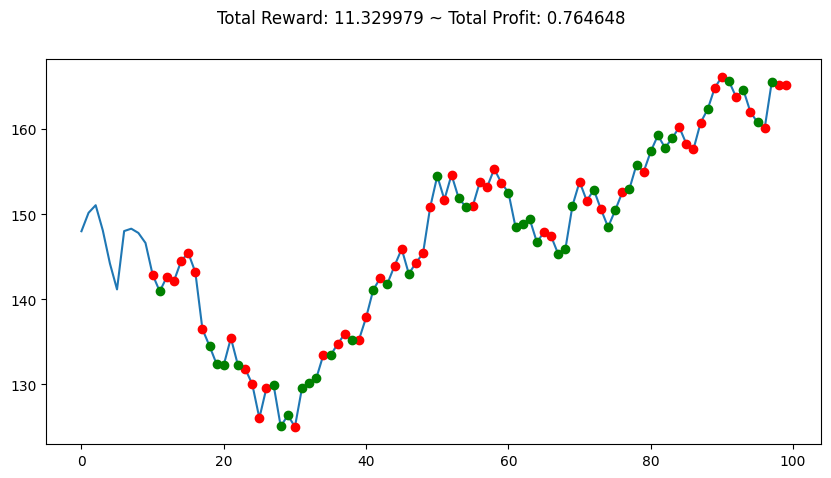

In [126]:
observation = env_test.reset()
states = []


while True:
    action = env_test.action_space.sample()
    observation, reward, done, info = env_test.step(action)
    states.append(observation)
    if done:
        print("info:", info)
        break

plt.figure(figsize=(10, 5))
plt.cla()
env_test.render_all()
plt.show(); 

In [83]:
lr = cfg["ppo"]["hyperparameters"]["lr"]
episodes = cfg["ppo"]["hyperparameters"]["episodes"]
max_actions = cfg["ppo"]["hyperparameters"]["max_actions"]

epsilon = cfg["ppo"]["hyperparameters"]["epsilon"]
steps = cfg["ppo"]["hyperparameters"]["steps"]
n_exps = cfg["ppo"]["hyperparameters"]["n_exps"]
profit_threshold = cfg["ppo"]["hyperparameters"]["profit_threshold"]
gamma = cfg["ppo"]["hyperparameters"]["gamma"]

hidden_dim = cfg["ppo"]["actor_critic"]["hidden_dim"]
n_layers = cfg["ppo"]["actor_critic"]["n_lstm_layers"]

In [84]:
n, m = env_train.observation_space.shape

nn_args = {
    "input_dim": m,
    "hidden_dim": hidden_dim,
    "n_layers": n_layers, 
    "device": DEVICE
}

actor = MLPLSTM(output_dim=env_train.action_space.n, **nn_args)
critic = MLPLSTM(output_dim=1, **nn_args)

ppo = ActorCritic(actor, critic)
ppo

ActorCritic(
  (actor): MLPLSTM(
    (lstm): LSTM(2, 256, num_layers=2, batch_first=True)
    (linear): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): MLPLSTM(
    (lstm): LSTM(2, 256, num_layers=2, batch_first=True)
    (linear): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [85]:
optimizer = optim.Adam(ppo.parameters(), lr = lr)

train_rewards, test_rewards = [], []

train_profits, test_profits = [], []

loop = trange(1, episodes+1) 

for episode in loop:
    
    clip_loss, value_loss, train_reward, train_profit = train_one_episode(
        env_train, 
        ppo, 
        optimizer, 
        gamma, 
        steps, 
        epsilon, 
        max_actions)
    
    test_reward, test_profit = evaluate_one_episode(env_test, ppo, max_actions)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    train_profits.append(train_profit)
    test_profits.append(test_profit)

    msg = f"Episode {episode:3} | Train Cumulative Profits: {train_profit:7.1f} | Test Cumulative Profits: {test_profit:7.1f} |"
    loop.set_description(msg)

    if test_profit >= profit_threshold:
        print(f"Reached reward {str(profit_threshold)} in {episode} episodes")
        save_weights(ppo, f"ppo_{profit_threshold}_{episode}.pt")
        
        break

  0%|          | 0/100 [00:00<?, ?it/s]

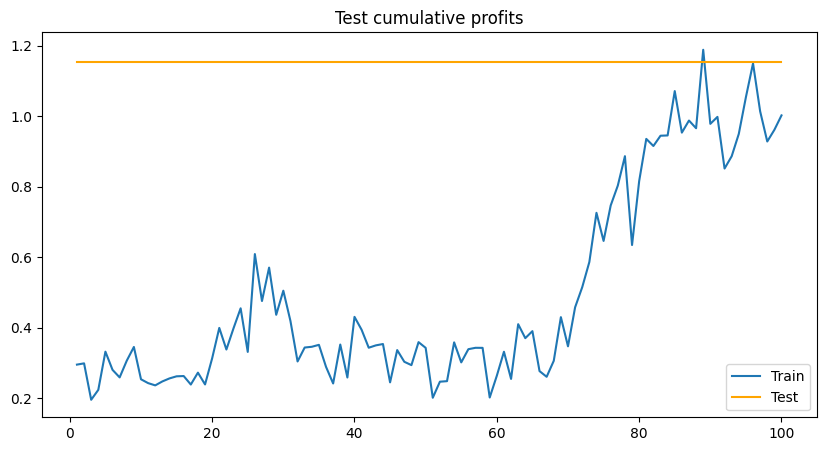

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=range(1, episodes+1), y=train_profits, ax=ax, label="Train")
sns.lineplot(x=range(1, episodes+1), y=test_profit, ax=ax, label="Test", color="orange")

ax.set_title("Test cumulative profits"); 